# Monte Carlo Ferromagnet
Christina C Lee
Physics Prerequisites: Statistics Mechanics/ Phase Transitions
Numerics Prerequisite: Monte Carlo Markov Chain

## The physics
What process turns liquid water into a solid?  As objects cool down, they transition from a regime where the desire to maximize entropy dominates to a regime where the desire to minimize energy dominates.   In transitions like liquid-solid, the energy arises from atom-atom long range forces, and therefore is a difficult problem to solve.

Instead of looking at the liquid-solid problem to understand phase transitions, we will look at a material (like magnetite) going from magnetized to non-magnetized (paramagnetic). In our approximation of the problem, the atoms exist at fixed positions on a lattice, and interact with their neighbor according to the following Hamiltonian,
\begin{equation}
    {\cal H} = -J \sum_{<i,j>} S^z_i S_j^z
\end{equation}
, which is basically just the energy.  This <i>Ising</i> Model has nearest neighbors interacting, and each solely points in the $\pm z$ direction.  

At a given temperature $T$, and thus inverse temperature $\beta=1/T$ ($k_b=1$), the occupancy of a given configuration $c_i$ follows the Maxwell-Boltzmann Distribution,
\begin{equation}
P(c_i)=\frac{\mathrm{e}^{-\beta E(c_i)}}{\sum\limits_j \mathrm{e}^{-\beta E(c_j)}}
\end{equation}

## The Numerics

In the post on the Markov Chain, each state was a location on our grid.  Now our state is one configuration of all our $N$ spins.  That means for an Ising spin we have $2^N$ different configurations.  Yeah... We aren't going to be exploring all of those.  

So how do we get from one state to the next? 

First, we choose a spin that we could flip.  This potential spin is chosen randomly for convenience's sake.  

Then we use the <b>Metropolis-Hastings Algorithm</b> to decide whether or no to flip the spin and generate a new configuration.  

We split the solution into two cases based on $\alpha = \frac{\pi_i}{\pi_j}$:

* If $\alpha > 1$ then always accept the transition, $p_{i \to j} = 1$
* If $\alpha < 1$, accept the transition with probability $\alpha = p_{i \to j}$


### Detailed Balance

From the Monte Carlo Markov Chain post, we take our equation for detailed balance

\begin{equation}
\frac{p_{i \to j}}{ p_{j \to i}} = \frac{\pi_i}{\pi_j}
\end{equation}


Make sure yourself this works.   

For the Ising Ferromagnet, our alpha is
\begin{equation}
\alpha= \frac{Z}{Z} \frac{\mathrm{e}^{-\beta E_i}}{\mathrm{e}^{-\beta E_j}} 
= \mathrm{e}^{\beta \left(E_j - E_i \right)}
\end{equation}
which is simply the difference in energy between two states.  Therefore we don't need to know the absolute energy at each point in time, just how the spin flip changes its local environment.  

## Tunable Parameters

I will say a little bit about the tunable parameters here, but Monte Carlo simulations are as much an art as a science, so I leave it up to you to play with the numbers and build intuition for what works.  

### Temperature

<img src="Ferromagnet/couch1.JPG" width="200px" style="float: left; margin: 20px"/> <img src="Ferromagnet/mountain.jpg" width="200px" style="float: right; margin: 20px"/>
On the left I am performing a low temperature search of a couch store.  I found a minimum, and even though I got stuck there, I thoroughly got to know what that minimum had to offer. On the right though, I'm performing a high temperature search of the Alexander Hills, Death Valley, California in pursuit of Neoproterzoic carbonates and dimictites.  I needed to be able to explore a lot more of the environment.  

While in a physical system like a magnet, temperature has a physical meaning, we can create other types of situations, like optimization or approximating a probability distribution, where we use temperature to describe how stuck we are to a particular minimum.  This intuition also plays a role in interpreting the results of of our simulation. 

Temperature can also provide other complications when we are studying critical phenomena, phase transitions.  Near the critical temperature, computations get much more difficult.  Elaboration in later post.

### Size of Lattice

* Larger lattice gives us more precise results.
* Larger lattice takes more memory and time.  
* Finite Size effects (to be disscussed later) display some interesting physics.

### Coupling Constant J

Usually normalized out anyway...

### Number of time steps

Each Monte Carlo time step is one complete sweep of the lattice ($N$ random flip attempts).  The more time steps, the more accurate the results, but the longer you have to wait.

### When to Measure

Though a time step does include $N$ spin flips, that doesn't mean we have actually moved to a truly new configuration.  If we want to randomly sample our configuration space, we need to wait a bit longer to sample.  Too short a time, and our measurements are coupled and not accurate.  Too long, and we are wasting computations.  In a later post, I will look at the autocorrelation time, which is a good way to figure our if your measurement time is good.  

### Other potential Options

Some less important things: periodic versus open boundary conditions, shape and symmetries of simulation cell.

In [5]:
using PyPlot;
push!(LOAD_PATH,".")
using Lattices;

Instead of going into calculating all the lattice parameters again, we will use a class I define in the file Lattices.jl .  This class contains

Lattice Types
* Chain
* Square
* Honeycomb

and once a lattice is created, it contains

Members of Type
* name  , a string
* l , length in number of unit cells
* dim, dimension of lattice
* a, array containing the basis vectors by which positions are generated
* unit. array of positions inside a single unit
* N , number of total sites
* X, array of positions
* nnei, number of nearest neighbors
* neigh, Array of nearest neighbors [i][j], where i is site and j is 1:nnei

Today, I will just look at the square lattice, since that indicates much of the standard phase transition properties.  Some of the lattices I have shown (kagome, triangular, ...) are special frustrated lattices, and thus will behave very wierdly in this situation.

In [9]:
## Define l here
l=50;

sq=MakeLattice("Square",l);
S=ones(Int8,l,l);  #Our spins
dt=1/(sq.N);

In [8]:
# The energy contribution of just one site
function dE(i::Int)
    Eii=0;
    for j in 1:sq.nnei
        Eii+=S[sq.neigh[i,j]];
    end
    Eii*=-J*S[i];  # we are computing J sz_i sz_j for one i
    return Eii;
end
# The energy of the entire lattice
function E()
    Evar=0;
    for k in 1:sq.N
        Evar+=.5*dE(k);
    end
    return Evar;
end
# The magnetization of the entire lattice
function M()
    Mvar=0;
    for k in 1:sq.N
        Mvar+=S[k];
    end
    return Mvar;
end
"defined functions"

"defined functions"

# Adjustable Parameters

In [50]:
beta=.2;
J=1;
t=100000;
nskip=10;   # don't measure every sweep= better decorrelation
"Parameters set"

"Parameters set"

In [51]:
nmeas=Int64(t/nskip); # how many times we will measure
Ma=Array{Int32}(nmeas); # our magnetization measurements
Ea=Array{Int32}(nmeas); # our energy measurements
"done"

"done"

In [52]:
tm=1; #Our measurement time step
pygui(true)
for ti in 1:t
    for j in 1:sq.N
        i = rand(1:sq.N); #Choosing a random site
        de=dE(i);
        if(de>0 || rand()<exp(2*beta*de) ) 
            S[i]=-S[i]; #Switch the sign
        end
    end
    if isapprox(mod(ti,nskip),0)
        Ma[tm]=M();
        Ea[tm]=E();
        tm+=1;
        
        #Uncomment to get a nice color plot of the lattice
        #pcolor(S,cmap="winter")
        #temp=round(M()/sq.N,3)
        #title("t: $ti  M: $temp ")
        #draw()
        #sleep(.5)
        #nm=dec(ti,4)
        #savefig("Magnetimages/picl30_b2_$nm.png")
    end
end
Mave=mean(Ma/sq.N);
Mstd=std(Ma/sq.N);
Eave=mean(Ea/sq.N);
Estd=std(Ea/sq.N);
Mave, Mstd

(-1.504000000000012e-5,0.0338605610638388)

In [ ]:
pygui(true)
pcolor(reshape(S,10,10),cmap="winter")

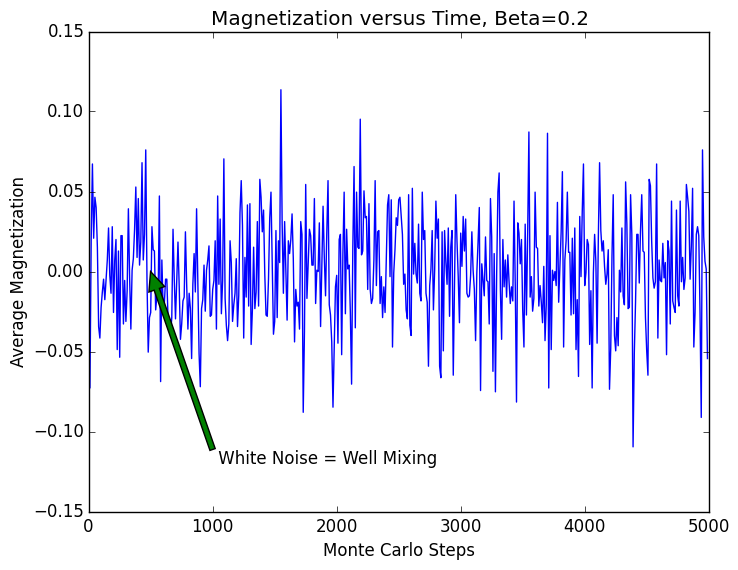

PyObject <matplotlib.text.Annotation object at 0x335547710>

In [34]:
pygui(false)
title("Magnetization versus Time, Beta=0.2")
xlabel("Monte Carlo Steps")
ylabel("Average Magnetization")
plot(collect(1:10:5000),Ma[1:500]/sq.N)
annotate(" White Noise = Well Mixing",
    xy=[500, 0 ],
    xytext=[1000, -.12],
    xycoords="data",
    arrowprops=Dict("facecolor"=>"green"))

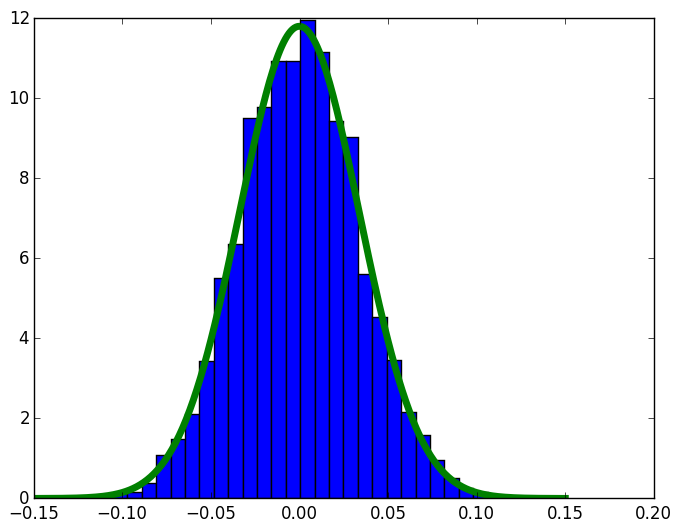

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x33716bd50>

In [48]:
pygui(false)
plt[:hist](Ma/sq.N,bins=30,normed=true);
x=collect(-.15:.001:.15)
gaussian=1/(Mstd*sqrt(2*pi))*exp(-(x-Mave).^2/(2*Mstd^2));
plot(x,gaussian,linewidth=5)

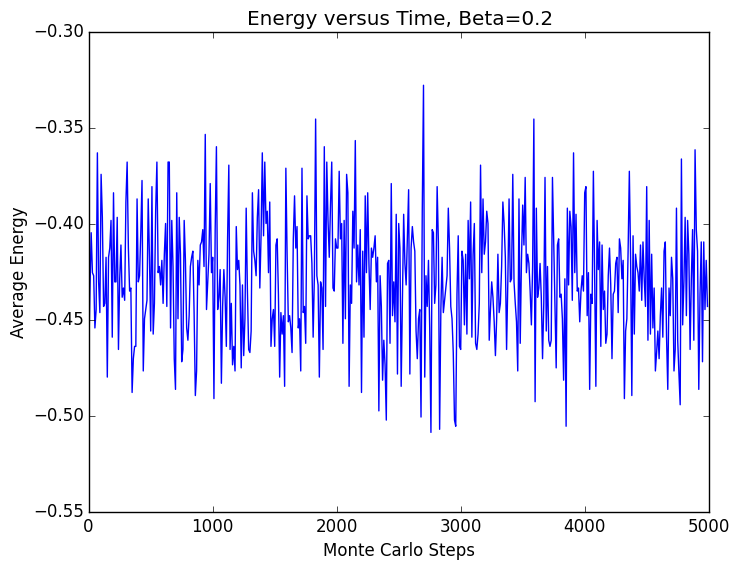

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x33742f950>

In [53]:
pygui(false)
title("Energy versus Time, Beta=0.2")
xlabel("Monte Carlo Steps")
ylabel("Average Energy")
plot(collect(1:10:5000),Ea[1:500]/sq.N)
#annotate(" White Noise = Well Mixing",
 #   xy=[500, 0 ],
  #  xytext=[1000, -.12],
   # xycoords="data",
    #arrowprops=Dict("facecolor"=>"green"))

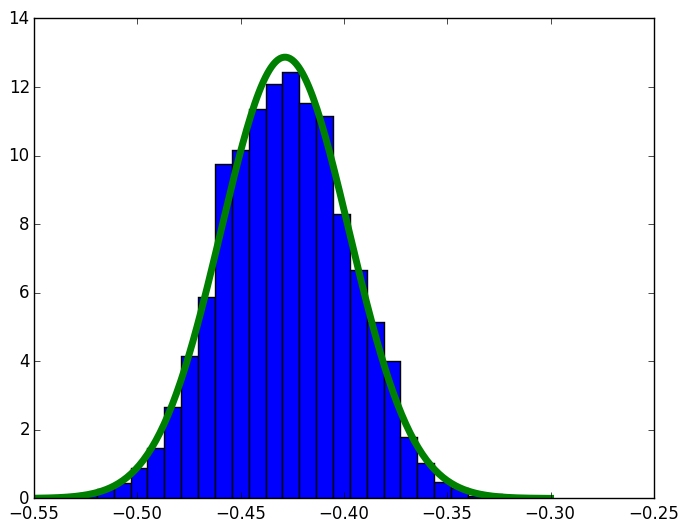

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x3119dce50>

In [63]:
pygui(false)
plt[:hist](Ea/sq.N,bins=30,normed=true);
x=collect(-.55:.001:-.3)
gaussian=1/(Estd*sqrt(2*pi))*exp(-(x-Eave).^2/(2*Estd^2));
plot(x,gaussian,linewidth=5)

## Example Results
So here are some example results I got.


![paramagnet gif](Ferromagnet/ParamagnetL30_b2.gif)
![magnetization](Ferromagnet/mt.png)